# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from google.colab import output

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:

**Запуск базовой модели с семинара на новом датасете (1 балл)**

На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# Решение

## Эксперимент 0. Модель с семинара

Модифицируем модель из семинарского ноутбука, и попробуем при помощи нее решить поставленную задачу. Для этого ее нужно адаптировать под нужное количество классов, в семинаре их было два, а в данном случае - четыре.

In [10]:
# Model from the seminar
class CharLM(nn.Module):
    def __init__(self,
                 hidden_dim: int,
                 vocab_size: int,
                 num_classes: int = 2,
                 aggregation_type: str = 'max',
                 n_layers: int = 1,
                 is_gru: bool = False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        if is_gru:
            self.rnn = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first=True)
        else:
            self.rnn = nn.RNN(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch) # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings) # [batch_size, seq_len, hidden_dim]
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) # [batch_size, hidden_dim]
        else:
            raise ValueError('Invalid aggregation_type')

        output = self.dropout(self.linear(self.non_lin(output))) # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output)) # [batch_size, num_classes]
        return prediction

In [11]:
def train_model(model,
                num_exp,
                train_loader,
                eval_loader,
                loss_criterion,
                opt,
                num_epochs = 5):
    '''
    Training loop of one model
    '''
    max_accuracy = 0
    accuracy_list = []
    loss_list = []
    model = model.to(device)
    eval_steps = len(train_loader) // 2

    for epoch in tqdm(range(num_epochs)):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(train_loader):
            opt.zero_grad()
            logits = model(batch['input_ids'].to(device))
            loss = loss_criterion(logits, batch['label'].to(device))
            loss.backward()
            opt.step()
            epoch_losses.append(loss.item())
            if not i % eval_steps:
                model.eval()
                accuracy = evaluate(model, eval_loader)
                accuracy_list.append(accuracy)
                model.train()
        epoch_loss = np.array(epoch_losses).mean()
        loss_list.append(epoch_loss)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'accuracy': accuracy,
                'loss': epoch_loss
            }
            torch.save(best_checkpoint, f'best_checkpoint_{num_exp}.tar')
        history = {
            'losses': loss_list,
            'accuracies': accuracy_list
        }
        torch.save(history, f'history_{num_exp}.tar')
    return history

In [ ]:
for i, ag_type in enumerate(['max', 'mean']):
    results = {}
    print(f'Training CharLM with {ag_type} pooling')
    model = CharLM(hidden_dim=256,
                   vocab_size=len(vocab),
                   num_classes=4,
                   aggregation_type=ag_type)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    train_model(model, i, train_dataloader, eval_dataloader, criterion, optimizer, num_epochs = 10)

Training CharLM with max pooling


  0%|          | 0/10 [00:00<?, ?it/s]

Training CharLM with mean pooling


  0%|          | 0/10 [00:00<?, ?it/s]

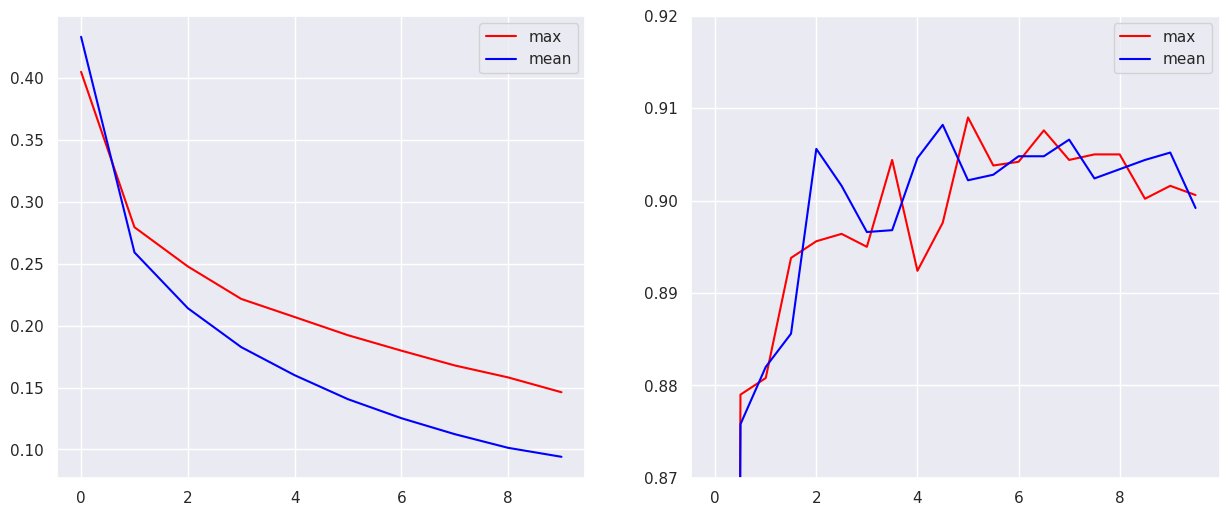

In [14]:
losses = {}
losses['max'] = torch.load('history_0.tar')
losses['mean'] = torch.load('history_1.tar')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.plot(losses['max']['losses'], color='r', label='max')
ax1.plot(losses['mean']['losses'], color='b', label='mean')
ax1.legend()
ax2.plot(np.arange(0, 10, 0.5), losses['max']['accuracies'], color='r', label='max')
ax2.plot(np.arange(0, 10, 0.5), losses['mean']['accuracies'], color='b', label='mean')
ax2.legend()
ax2.set_ylim(0.87,0.92)
plt.show()

In [15]:
print('Максимальное значение accuracy для max pooling: ', max(losses['max']['accuracies']))
print('Максимальное значение accuracy для average pooling: ', max(losses['mean']['accuracies']))

Максимальное значение accuracy для max pooling:  0.9089999794960022
Максимальное значение accuracy для average pooling:  0.9081999659538269


Итак, "базовым" значением accuracy будет 0.909. Нужно понять, как модифицировать нашу модель, чтобы попытаться улучшить его.

## Эксперимент 1. GRU

Теперь попробуем использовать для решения нашей задачи GRU - более "продвинутый" вариант RNN. Посмотрим, даст ли его применение прирост в качестве решения.

In [ ]:
for i, ag_type in enumerate(['max', 'mean']):
    results = {}
    print(f'Training CharLM with {ag_type} pooling')
    model = CharLM(hidden_dim=256,
                   vocab_size=len(vocab),
                   num_classes=4,
                   aggregation_type=ag_type,
                   is_gru=True)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    train_model(model, i + 2, train_dataloader, eval_dataloader, criterion, optimizer, num_epochs = 10)

Training CharLM with max pooling


  0%|          | 0/10 [00:00<?, ?it/s]

Training CharLM with mean pooling


  0%|          | 0/10 [00:00<?, ?it/s]

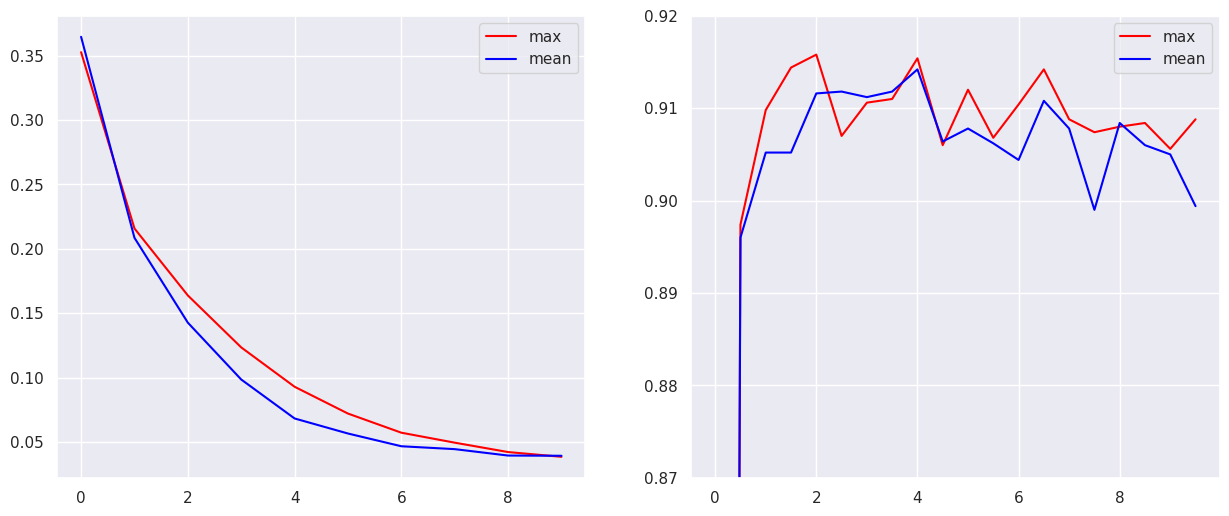

In [17]:
losses = {}
losses['max'] = torch.load('history_2.tar')
losses['mean'] = torch.load('history_3.tar')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.plot(losses['max']['losses'], color='r', label='max')
ax1.plot(losses['mean']['losses'], color='b', label='mean')
ax1.legend()
ax2.plot(np.arange(0, 10, 0.5), losses['max']['accuracies'], color='r', label='max')
ax2.plot(np.arange(0, 10, 0.5), losses['mean']['accuracies'], color='b', label='mean')
ax2.legend()
ax2.set_ylim(0.87,0.92)
plt.show()

In [18]:
print('Максимальное значение accuracy для max pooling: ', max(losses['max']['accuracies']))
print('Максимальное значение accuracy для average pooling: ', max(losses['mean']['accuracies']))

Максимальное значение accuracy для max pooling:  0.9157999753952026
Максимальное значение accuracy для average pooling:  0.914199948310852


После проведения этого эксперимента качество улучшилось до 0.916 и 0.914 соответственно для max и average pooling.

## Эксперимент 2. Увеличение кол-ва слоев RNN

До настоящего момента мы пользовались однослойной сетью. Если добавить новые слои в модель, то она в теории сможет выучить более сложные зависимости в исходном тексте. Поставим эксперимент, чтобы выяснить это предположение.

In [ ]:
i = 4
for num_layers, ag_type in zip([2, 2, 3, 3, 4, 4], ['max', 'mean']*3):
    results = {}
    print(f'Training CharLM with {num_layers} RNN layers and {ag_type} pooling')
    model = CharLM(hidden_dim=256,
                   vocab_size=len(vocab),
                   num_classes=4,
                   n_layers=num_layers,
                   aggregation_type=ag_type)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    train_model(model, i, train_dataloader, eval_dataloader, criterion, optimizer, num_epochs = 10)
    i += 1

Training CharLM with 2 RNN layers and max pooling


  0%|          | 0/10 [00:00<?, ?it/s]

Training CharLM with 2 RNN layers and mean pooling


  0%|          | 0/10 [00:00<?, ?it/s]

Training CharLM with 3 RNN layers and max pooling


  0%|          | 0/10 [00:00<?, ?it/s]

Training CharLM with 3 RNN layers and mean pooling


  0%|          | 0/10 [00:00<?, ?it/s]

Training CharLM with 4 RNN layers and max pooling


  0%|          | 0/10 [00:00<?, ?it/s]

Training CharLM with 4 RNN layers and mean pooling


  0%|          | 0/10 [00:00<?, ?it/s]

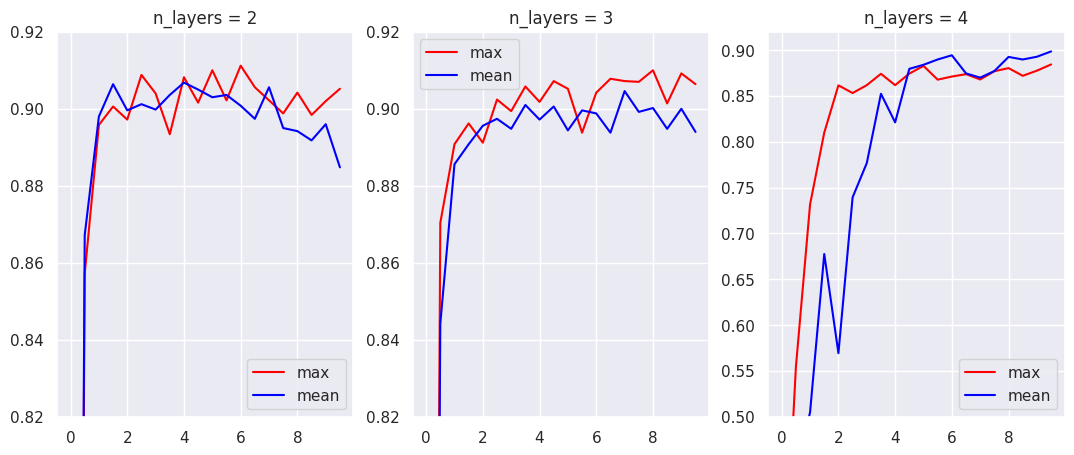

In [26]:
losses = {2: {}, 3: {}, 4: {}}
for i in range(4, 10, 2):
    losses[i // 2]['max'] = torch.load(f'history_{i}.tar')
    losses[i // 2]['mean'] = torch.load(f'history_{i+1}.tar')
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,5))
ax1.plot(np.arange(0, 10, 0.5), losses[2]['max']['accuracies'], color='r', label='max')
ax1.plot(np.arange(0, 10, 0.5), losses[2]['mean']['accuracies'], color='b', label='mean')
ax1.legend()
ax1.set_ylim(0.82,0.92)
ax1.set_title('n_layers = 2')
ax2.plot(np.arange(0, 10, 0.5), losses[3]['max']['accuracies'], color='r', label='max')
ax2.plot(np.arange(0, 10, 0.5), losses[3]['mean']['accuracies'], color='b', label='mean')
ax2.legend()
ax2.set_ylim(0.82,0.92)
ax2.set_title('n_layers = 3')
ax3.plot(np.arange(0, 10, 0.5), losses[4]['max']['accuracies'], color='r', label='max')
ax3.plot(np.arange(0, 10, 0.5), losses[4]['mean']['accuracies'], color='b', label='mean')
ax3.legend()
ax3.set_ylim(0.5,0.92)
ax3.set_title('n_layers = 4')
plt.show()

In [27]:
print('Максимальное значение accuracy для max pooling: ')
[print(f'n_layers={i}:', max(losses[i]['max']['accuracies'])) for i in [2,3,4]]
print('Максимальное значение accuracy для average pooling: ')
[print(f'n_layers={i}:', max(losses[i]['mean']['accuracies'])) for i in [2,3,4]]
None

Максимальное значение accuracy для max pooling: 
n_layers=2: 0.9111999869346619
n_layers=3: 0.9099999666213989
n_layers=4: 0.884399950504303
Максимальное значение accuracy для average pooling: 
n_layers=2: 0.9067999720573425
n_layers=3: 0.9045999646186829
n_layers=4: 0.8985999822616577


# Вывод

В данной работе была обучена RNN для классификации текста. Было проведено три эксперимента при различных значениях гиперпараметров. Удалось достичь **максимального качества в 0.9158** по метрике accuracy. По поводу проведенных практических исследований можно сделать следующие выводы:

*   Почти во всех экспериментах наилучшие значения метрики accuracy достигаются на 4-7 эпохах обучения. Вероятно, дальше накапливается эффект переобучения, для борьбы с которым в теории можно увеличить размер словаря либо размер скрытых слоев RNN.
*   Применение GRU дало ощутимый прирост в метрике. В этом эксперименте было достигнуто самое большое значение accuracy.
*   Эксперимент с увеличением количества слоев RNN не принес улучшения. Более того, по графикам видно, что чем больше это количество, тем меньшего качества достигает модель. Видимо, в этом случае нужно дополнительно изменять еще какие-то параметры.
*   Лучше всего сходится модель с GRU. Вообще, графики лоссов довольно плавные, а метрика accuracy почти везде изменяется скачкообразно. Она наиболее стабильна у RNN с 1-2 слоями.